### Welcome to the program
Anything you will need will be in this file.

First let some modules to download

In [ ]:
!pip install ipywidgets;


In [2]:
import utils
import os

import torch

import ipywidgets as widgets
from IPython.display import display

from fairness_metrics.predicted_probs.balance_in_pos_neg import balance_in_pos_neg
from fairness_metrics.Predicted_outcomes.unconditional_statistical_parity import statistical_parity
from fairness_metrics.predicted_probs.well_callibrated import well_calibration

In [3]:

INPUT_FILE_NAME = widgets.Text(
    placeholder='Type file name',
    description='File name:',
    tooltip='do not forget the file extension'
)
PRESET_FILENAME = INPUT_FILE_NAME.value if INPUT_FILE_NAME.value else 'No file'
file_exits = os.path.exists(utils.SAVED_PRESET_PATH + PRESET_FILENAME)
FILE_FOUND = widgets.Valid(
    value=file_exits,
    style = {'description_width': 'initial'},
    description=f'Preset file "{PRESET_FILENAME}"',
    tooltip='Indicates if the chosen file has been found'
)
USE_PRESET= widgets.RadioButtons(
    options=[('Yes', 1), ('No', 0)],
    value=file_exits,
    disabled=not(file_exits),
    style = {'description_width': 'initial'},
    description='Load preset file:',
)

info_box = widgets.VBox([
    widgets.Label(value=f'Select your preset file here, They must be in the folder "{utils.SAVED_PRESET_PATH}"'),
    INPUT_FILE_NAME,
    FILE_FOUND,
    USE_PRESET,
])

output_file_selection = widgets.Output()
display(info_box, output_file_selection)

def update_file_name_info(_):
    with output_file_selection:
        PRESET_FILENAME = INPUT_FILE_NAME.value if INPUT_FILE_NAME.value else 'No file'
        file_exits = os.path.exists(os.path.join(utils.SAVED_PRESET_PATH + PRESET_FILENAME))
        FILE_FOUND.description = f'Preset file "{PRESET_FILENAME}"'
        FILE_FOUND.value = file_exits
        USE_PRESET.value = file_exits
        USE_PRESET.disabled=not(file_exits)

INPUT_FILE_NAME.on_trait_change(update_file_name_info)

Output()

In [4]:
# dataset = utils.Dataset(utils.DATA_PATH_SYNTH)
dataset = utils.Dataset('data/altered_data/data_pred_ground_altered_pred.csv')

preset = {}
if USE_PRESET.value:
    preset = torch.load(utils.SAVED_PRESET_PATH + INPUT_FILE_NAME.value)

/tmp/ipykernel_102864/62064646.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  preset = torch.load(utils.SAVED_PRESET_PATH + INPUT_FILE_NAME.value)


In [5]:
# testing column selection

from ipywidgets import Layout, VBox, Label, Box, Checkbox

style = {'background':'white'}
item_layout = Layout(width='auto')

protected_items = [Checkbox(layout=item_layout, description=dataset.i2c[i], indent=False, style=style) for i in range(len(dataset.i2c))]

box_layout = Layout(overflow='hidden scroll',
                    border='empty',
                    width='auto',
                    height='300px',
                    flex_flow='column',
                    display='flex',
                    padding='0')

PROTECTED_SELECTION = Box(children=protected_items, layout=box_layout)
GROUND_SELECTION = widgets.Combobox(
    value=None,
    placeholder='Choose a feature',
    options=dataset.i2c+[''],
    description='Ground truth:',
    ensure_option=True,
    style={'description_width':'150px'},
    layout=widgets.Layout(width='auto'),
)
PREDICTED_SELECTION = widgets.Combobox(
    value=None,
    placeholder='Choose a feature',
    options=dataset.i2c+[''],
    description='Predicted by model:',
    ensure_option=True,
    style={'description_width':'150px'},
    layout=widgets.Layout(width='auto'),
)
FEEDBACK_INFO_SLECETION = widgets.Label(
    value='',
)

SELECTION_BOX = VBox([
    Label('Please select the ground truth and the predicted probability (if available):'), 
    GROUND_SELECTION,
    PREDICTED_SELECTION,
    FEEDBACK_INFO_SLECETION,
    Label('Please select all protected variables:'), 
    PROTECTED_SELECTION,
    ])

if USE_PRESET.value:
    preset_protected_values = preset.get('protected_values', torch.zeros(len(dataset.i2c), dtype=bool))
    for item, value in zip(protected_items, preset_protected_values):
        item.value = bool(value)
    GROUND_SELECTION.value=preset.get('ground_truth_column', '')
    PREDICTED_SELECTION.value=preset.get('prediction_column', '')

output_selection = widgets.Output()
display(SELECTION_BOX, output_selection)

def update_selection_feedback(id):
    with output_selection:
        if GROUND_SELECTION.value == PREDICTED_SELECTION.value != '':
            FEEDBACK_INFO_SLECETION.value=f'Both are now selected as "{GROUND_SELECTION.value}", Please make sure that the ground truth is not the same as the predictions'
        else:
            FEEDBACK_INFO_SLECETION.value='You have selected ' + (f'ground truth as "{GROUND_SELECTION.value}"' if GROUND_SELECTION.value else 'no ground truth') + ' and ' + (f'predictions as "{PREDICTED_SELECTION.value}"' if PREDICTED_SELECTION.value else 'no predictions')

GROUND_SELECTION.on_trait_change(update_selection_feedback)
PREDICTED_SELECTION.on_trait_change(update_selection_feedback)
SELECTION_BOX.on_widget_constructed(update_selection_feedback)

Output()

In [6]:
fairness_groups = []

groups = []

accordion = widgets.Accordion(children=[widgets.IntSlider(), widgets.Text()], titles=('Slider', 'Text'))
accordion

Accordion(children=(IntSlider(value=0), Text(value='')), titles=('Slider', 'Text'))

In [8]:
preset['protected_values'] = torch.tensor([protected_item.value for protected_item in protected_items])
preset['ground_truth_column'] = GROUND_SELECTION.value
preset['prediction_column'] = PREDICTED_SELECTION.value

metric1 = balance_in_pos_neg(dataset, preset)
metric2 = well_calibration(dataset, preset)
metric3 = statistical_parity(dataset, preset)

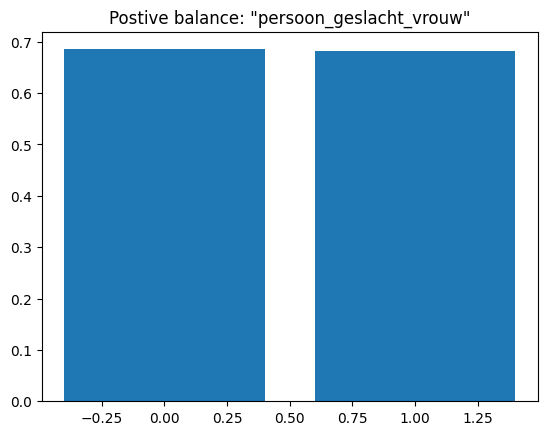

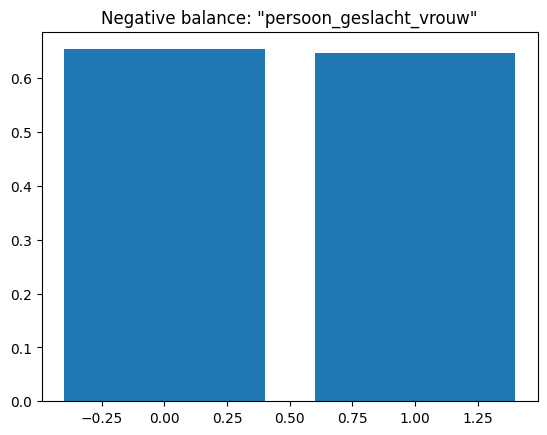

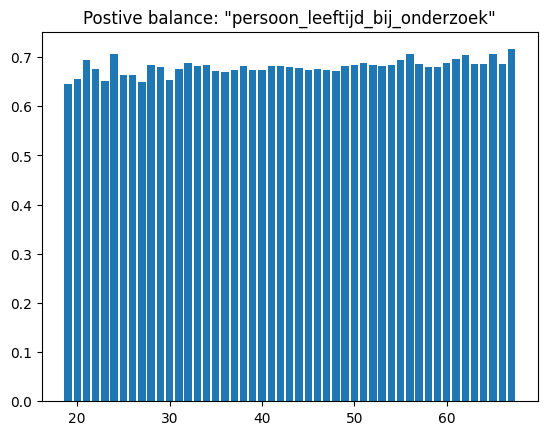

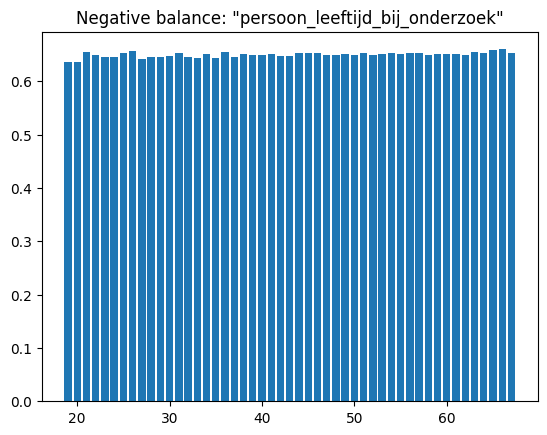

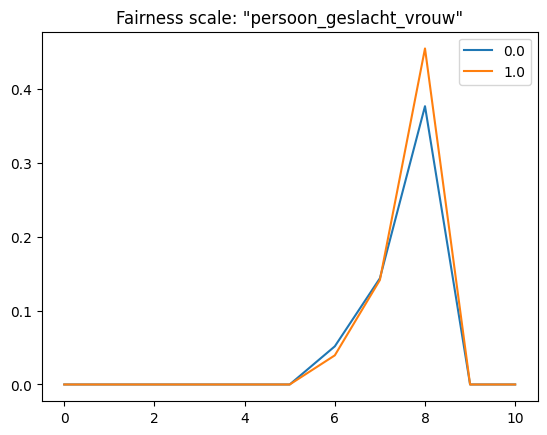

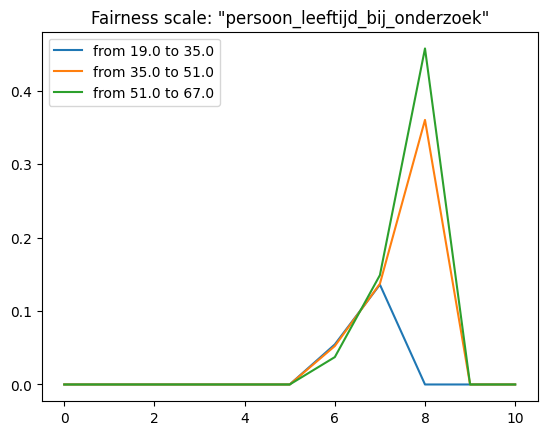

{'persoon_geslacht_vrouw': {'group_probs': {0: 0.00015285845438484102, 1: 0.0},
  'pairwise_differences': {(0, 1): 0.00015285845438484102},
  'fair': True},
 'persoon_leeftijd_bij_onderzoek': {'group_probs': {19: 0.0,
   20: 0.0,
   21: 0.0,
   22: 0.0,
   23: 0.0,
   24: 0.0,
   25: 0.0,
   26: 0.0,
   27: 0.0,
   28: 0.0,
   29: 0.0,
   30: 0.0,
   31: 0.0,
   32: 0.0,
   33: 0.0,
   34: 0.0,
   35: 0.0,
   36: 0.0,
   37: 0.0,
   38: 0.0,
   39: 0.0,
   40: 0.0,
   41: 0.0,
   42: 0.0,
   43: 0.0,
   44: 0.0,
   45: 0.0,
   46: 0.0,
   47: 0.0,
   48: 0.0,
   49: 0.0,
   50: 0.0,
   51: 0.0,
   52: 0.0,
   53: 0.0,
   54: 0.0,
   55: 0.0,
   56: 0.0,
   57: 0.0,
   58: 0.0,
   59: 0.0,
   60: 0.0,
   61: 0.0,
   62: 0.0,
   63: 0.0,
   64: 0.0,
   65: 0.0038759689778089523,
   66: 0.0,
   67: 0.0},
  'pairwise_differences': {(19, 20): 0.0,
   (19, 21): 0.0,
   (19, 22): 0.0,
   (19, 23): 0.0,
   (19, 24): 0.0,
   (19, 25): 0.0,
   (19, 26): 0.0,
   (19, 27): 0.0,
   (19, 28): 0.0,
 

In [ ]:
# metric1.show() ## this should be the only steps
metric2.show()
# metric3.check_statistical_parity()

In [ ]:
pos, neg = [0,0],[0,0]
pos += [.5, 1]
pos

In [ ]:
OUTPUT_FILE_NAME = widgets.Text(
    placeholder='Type output file name',
    description='File name:',
    tooltip='do not forget the file extension'
)
FEEDBACK_INFO = widgets.Label(
    value='',
)
SUBMIT_BUTTON = widgets.Button(
    description='Save preset',
    disabled=True,
    button_style='danger',
    tooltip='No file name',
)

info_box = widgets.VBox([
    widgets.Label(value=f'Select a name for your preset file here, This will be saved in the folder "{utils.SAVED_PRESET_PATH}"'),
    OUTPUT_FILE_NAME,
    SUBMIT_BUTTON,
    FEEDBACK_INFO,
])

output_savefile = widgets.Output()
display(info_box, output_savefile)


def update_file_name_info(id):
    with output_savefile:
        if type(id) == widgets.Button:
            preset['protected_values'] = torch.tensor([protected_item.value for protected_item in protected_items])
            preset['ground_truth_column'] = GROUND_SELECTION.value
            preset['prediction_column'] = PREDICTED_SELECTION.value

            torch.save(preset, utils.SAVED_PRESET_PATH + OUTPUT_FILE_NAME.value)
            FEEDBACK_INFO.value=f'Preset saved to "{OUTPUT_FILE_NAME.value}"'
        
        if type(id) == widgets.Text:
            FEEDBACK_INFO.value=''
        
        file_exits = os.path.exists(utils.SAVED_PRESET_PATH + OUTPUT_FILE_NAME.value)
        if OUTPUT_FILE_NAME.value == '':
            SUBMIT_BUTTON.button_style='danger'
            SUBMIT_BUTTON.tooltip='No file name'
            SUBMIT_BUTTON.disabled=True
        elif not OUTPUT_FILE_NAME.value.endswith('.pt'):
            SUBMIT_BUTTON.button_style='warning'
            SUBMIT_BUTTON.tooltip='Please make it a .pt file'
            SUBMIT_BUTTON.disabled=False
        elif file_exits:
            SUBMIT_BUTTON.button_style='info'
            SUBMIT_BUTTON.tooltip='A file already exists with this name, overwrite is possible'
            SUBMIT_BUTTON.disabled=False
        else:
            SUBMIT_BUTTON.button_style='success'
            SUBMIT_BUTTON.tooltip='Save file'
            SUBMIT_BUTTON.disabled=False

        
OUTPUT_FILE_NAME.on_trait_change(update_file_name_info)
SUBMIT_BUTTON.on_click(update_file_name_info)
